## Preparing features & labels

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [ ]:
dataset = tf.data.Dataset.range(10)       # dataset object to make values
for val in dataset:
   print(val.numpy())

0
1
2
3
4
5
6
7
8
9


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1)        # creates window in dataset of each row of 5 items
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 
6 7 8 9 
7 8 9 
8 9 
9 


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)     # taking only till that row which has 5 values
for window_dataset in dataset:
  for val in window_dataset:
    print(val.numpy(), end=" ")
  print()

0 1 2 3 4 
1 2 3 4 5 
2 3 4 5 6 
3 4 5 6 7 
4 5 6 7 8 
5 6 7 8 9 


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))     # converting each row to list
for window in dataset:
  print(window.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))        # splitting into Xs and y
for x,y in dataset:
  print(x.numpy(), y.numpy())

[0 1 2 3] [4]
[1 2 3 4] [5]
[2 3 4 5] [6]
[3 4 5 6] [7]
[4 5 6 7] [8]
[5 6 7 8] [9]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)                               # shuffling the rows
for x,y in dataset:
  print(x.numpy(), y.numpy())

[3 4 5 6] [7]
[1 2 3 4] [5]
[5 6 7 8] [9]
[4 5 6 7] [8]
[0 1 2 3] [4]
[2 3 4 5] [6]


In [ ]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)                                  # taking batch size of 2
for x,y in dataset:
  print("x = ", x.numpy())
  print("y = ", y.numpy())

x =  [[0 1 2 3]
 [2 3 4 5]]
y =  [[4]
 [6]]
x =  [[4 5 6 7]
 [3 4 5 6]]
y =  [[8]
 [7]]
x =  [[5 6 7 8]
 [1 2 3 4]]
y =  [[9]
 [5]]


## ML on Time Windows

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [ ]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):                      # shuffle_buffer determines how data will be shuffled
  dataset = tf.data.Dataset.from_tensor_slices(series)                                      # creates the dataset
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))                  # flatten data in size window_size+1
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))   # shuffled
  dataset = dataset.batch(batch_size).prefetch(1)                                           # batched into batch size and returned
  return dataset

In [ ]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [ ]:
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=50,verbose=0)

In [ ]:
print("Layer weights {}".format(l0.get_weights()))

# array 1 shows w1, w2,...w20
# array 2 shows bias

Layer weights [array([[-0.13685222],
       [-0.09372963],
       [ 0.20220107],
       [ 0.09758087],
       [-0.08466703],
       [ 0.07808802],
       [-0.10009411],
       [ 0.13686132],
       [-0.136463  ],
       [-0.03399771],
       [-0.00864965],
       [ 0.18018551],
       [-0.01080807],
       [-0.13184953],
       [ 0.01627256],
       [ 0.02204831],
       [ 0.20042294],
       [ 0.15005943],
       [ 0.18496956],
       [ 0.46603534]], dtype=float32), array([0.01043883], dtype=float32)]


In [ ]:
series[:20]

array([52.48357 , 49.35275 , 53.314735, 57.711823, 48.934444, 48.931244,
       57.982895, 53.897125, 47.67393 , 52.68371 , 47.591717, 47.506374,
       50.959415, 40.086178, 40.919415, 46.612473, 44.228207, 50.720642,
       44.454983, 41.76799 ], dtype=float32)

In [ ]:
model.predict(series[:20][np.newaxis])

array([[45.737053]], dtype=float32)

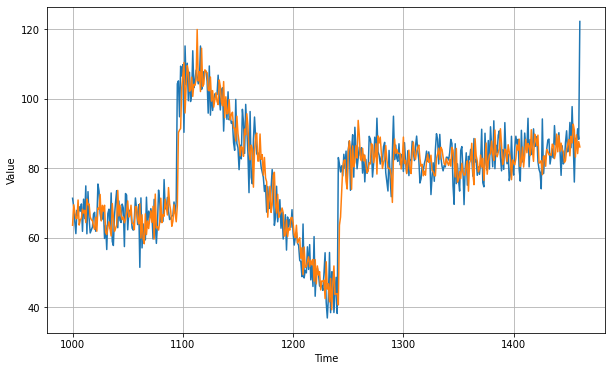

In [ ]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.2557197

## Using DNN to improve

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.09
noise_level = 5

# create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

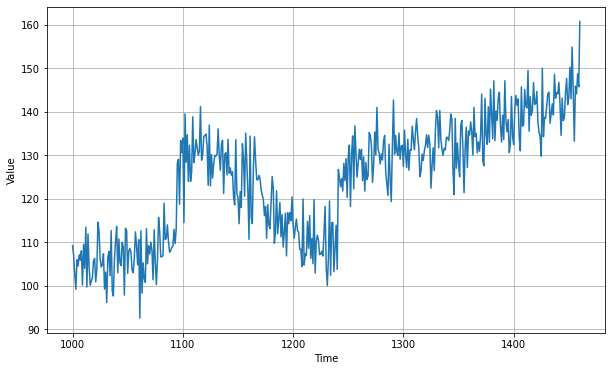

In [3]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [7]:
model = Sequential([
    layers.InputLayer(input_shape=[window_size]),
    layers.Dense(10, activation="relu"), 
    layers.Dense(10, activation="relu"), 
    layers.Dense(1)
])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [9]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
loss        = tf.keras.losses.MeanSquaredError()

In [10]:
model.compile(optimizer=optimizer,
              loss=loss)

In [11]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [12]:
epochs = 100
callbacks = [early_stopping, model_checkpoint]

In [13]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 449.0076
Epoch 2/100
31/31 [==============================] - 0s 5ms/step - loss: 57.9130
Epoch 3/100
31/31 [==============================] - 0s 6ms/step - loss: 50.0902
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 48.5942
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 49.4068
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 48.0920
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 48.6426
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 46.4608
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 46.0181
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 46.8961
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 44.9011
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 45.0071
Epoch 13/100
31/31 [====

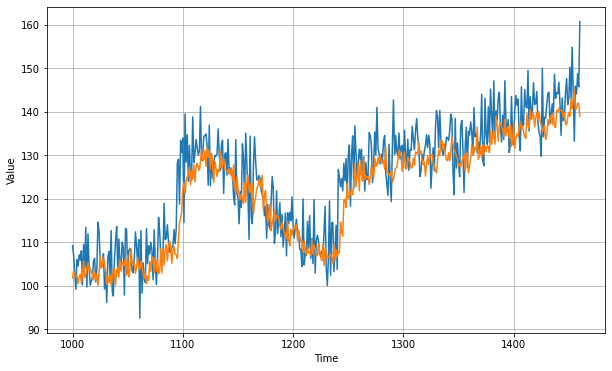

In [14]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [15]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

5.0854216

## Using DNN with LR Scheduler

In [4]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [5]:
model = Sequential([
    layers.InputLayer(input_shape=[window_size]),
    layers.Dense(10, activation="relu"), 
    layers.Dense(10, activation="relu"), 
    layers.Dense(1)
])

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [6]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
loss        = tf.keras.losses.MeanSquaredError()

In [7]:
model.compile(optimizer=optimizer,
              loss=loss)

In [8]:
# using Scheduler to monitor learning_rate

lr_schedule = tf.keras.callbacks.LearningRateScheduler(                         # changes LR to a value based on epoch number
    lambda epoch: 1e-8 * 10**(epoch / 20))                                      # eg: for epoch 1 -> 10^-8 * 10^(1/20), for epoch 100 -> 10^-8 * 10^(100/20)

In [9]:
early_stopping    = EarlyStopping(monitor='loss', patience=5)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [10]:
epochs = 100
callbacks = [early_stopping, model_checkpoint, lr_schedule]

In [11]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 2808.5173
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 1721.0055
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 974.1786
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 479.1927
Epoch 5/100
31/31 [==============================] - 0s 5ms/step - loss: 202.7823
Epoch 6/100
31/31 [==============================] - 0s 6ms/step - loss: 90.7580
Epoch 7/100
31/31 [==============================] - 0s 6ms/step - loss: 56.3078
Epoch 8/100
31/31 [==============================] - 0s 5ms/step - loss: 49.0066
Epoch 9/100
31/31 [==============================] - 0s 4ms/step - loss: 47.9483
Epoch 10/100
31/31 [==============================] - 0s 5ms/step - loss: 47.7817
Epoch 11/100
31/31 [==============================] - 0s 4ms/step - loss: 47.7041
Epoch 12/100
31/31 [==============================] - 0s 5ms/step - loss: 47.6588
Epoch 13/100
31/31

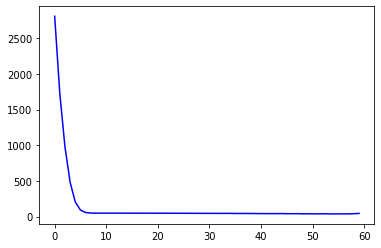

In [12]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

(1e-08, 0.0001, 0.0, 300.0)

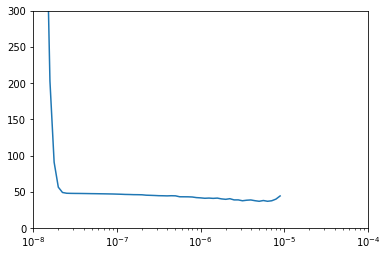

In [14]:
lrs = 1e-8 * (10 ** (np.arange(60) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 300])

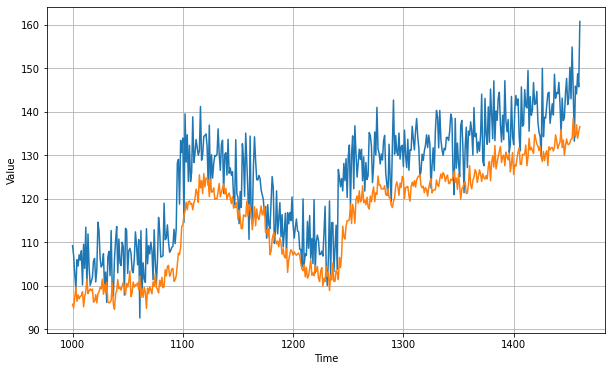

In [15]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [16]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

8.853245

In [18]:
best_model = tf.keras.models.load_model('best_model.h5')

In [19]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


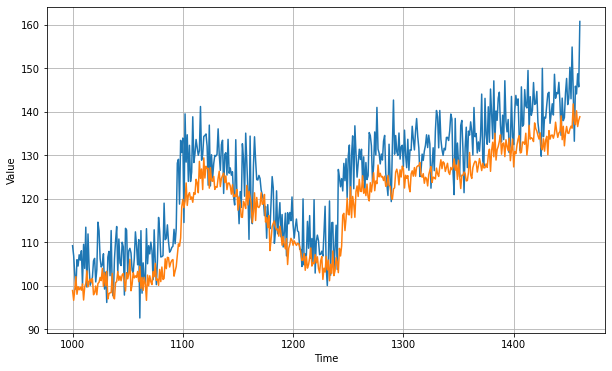

In [20]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(best_model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.953083

## Exercise 14

For this exercise you’ll create your own synthetic dataset -- I’ve plotted a chart for what it should look like, see if you can figure out the parameters that get this series.

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.6.0


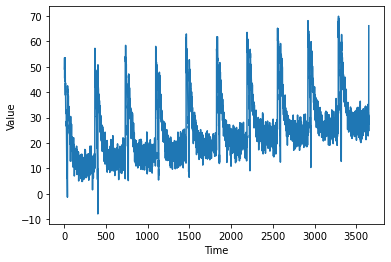

In [23]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 6 * np.pi),
                    2 / np.exp(9 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [24]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [25]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [26]:
model = Sequential([
    layers.InputLayer(input_shape=[window_size]),
    layers.Dense(100, activation="relu"), 
    layers.Dense(10, activation="relu"), 
    layers.Dense(1)
])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 3,121
Trainable params: 3,121
Non-trainable params: 0
_________________________________________________________________


In [28]:
optimizer   = tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9)
loss        = tf.keras.losses.MeanSquaredError()

In [29]:
model.compile(optimizer=optimizer,
              loss=loss)

In [30]:
early_stopping    = EarlyStopping(monitor='loss', patience=10)
model_checkpoint  = ModelCheckpoint(monitor='loss', filepath='./best_model.h5', save_best_only=True)

In [31]:
epochs = 100
callbacks = [early_stopping, model_checkpoint]

In [32]:
history = model.fit(dataset,
                    verbose = 1,
                    epochs = epochs,
                    callbacks = callbacks)

Epoch 1/100
94/94 [==============================] - 1s 7ms/step - loss: 59.6797
Epoch 2/100
94/94 [==============================] - 1s 7ms/step - loss: 36.1430
Epoch 3/100
94/94 [==============================] - 1s 7ms/step - loss: 31.4711
Epoch 4/100
94/94 [==============================] - 1s 7ms/step - loss: 29.2620
Epoch 5/100
94/94 [==============================] - 1s 7ms/step - loss: 27.8838
Epoch 6/100
94/94 [==============================] - 1s 8ms/step - loss: 27.3207
Epoch 7/100
94/94 [==============================] - 1s 7ms/step - loss: 26.1453
Epoch 8/100
94/94 [==============================] - 1s 8ms/step - loss: 25.6102
Epoch 9/100
94/94 [==============================] - 1s 7ms/step - loss: 25.4332
Epoch 10/100
94/94 [==============================] - 1s 7ms/step - loss: 24.8285
Epoch 11/100
94/94 [==============================] - 1s 7ms/step - loss: 24.7267
Epoch 12/100
94/94 [==============================] - 1s 7ms/step - loss: 24.6569
Epoch 13/100
94/94 [=====

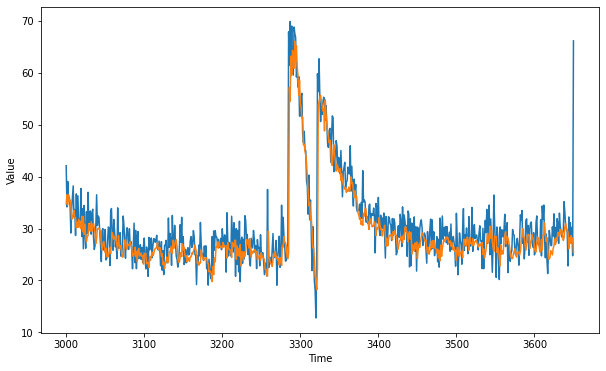

In [33]:
forecast = []

for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [34]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

3.0997012